# March 31, 2025

COSI 104-A Learning over Images

Here, we will demonstrate how one of our models can learn to classify images over a simple, bitmap representation.

This notebook is largely based on an SKlearn example found at https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html.


In [1]:

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split


First, we load the digits dataset.  It contains 1800 8x8 bitmaps of hand drawn digits.  This means each sample is a 64-dimensional vector.

(1797, 8, 8)


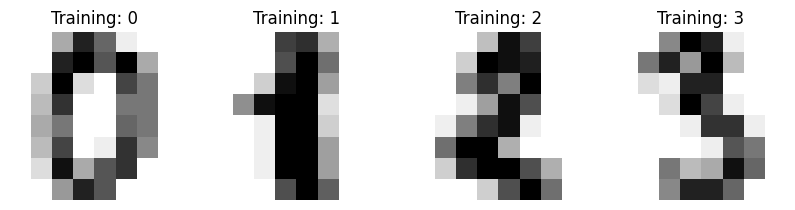

In [5]:
digits = datasets.load_digits()
print(digits.images.shape)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


First, we do some slight preprocessing - the original data space is flattened from 8x8 to 64x1 (i.e. from a matrix to a vector, essentially laying out each row of the image next to the previous one).  Then, an out-of-the-box Support Vector Machine Classifier is trained on half the images and tested on the other half.


In [40]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)


The first four examples of the testing set are shown, with their predicted class.

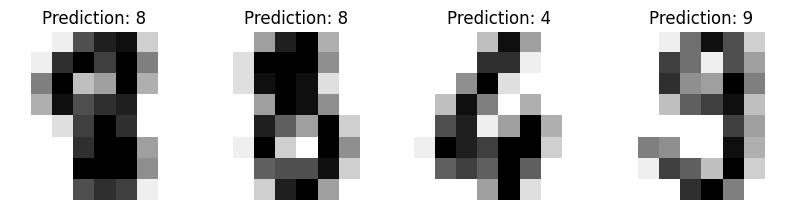

In [41]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

Lastly, we print a confusion matrix.  Overall the model gets an accuracy in the 80s.

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


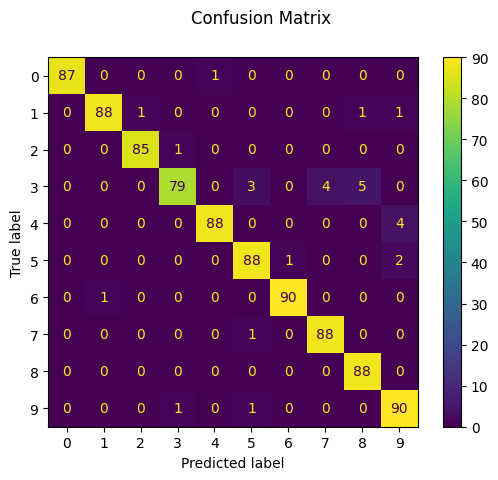

In [42]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()


## Evaluating performance

Overall, the SVM did pretty well!  We probably need to squeeze some higher performance out of it - imagine if your mail sorting got your zip code digits wrong 10% of the time - there'd be less than a 50% chance of it recognizing your whole zip code.

We can try to find a better representation for the problem by reducing the dimensionality.

In [43]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=16).fit(X_train)

X_transform_train = sklearn_pca.transform(X_train)
X_transform_test = sklearn_pca.transform(X_test)

# Create a classifier: a support vector classifier
clf_low_dim = svm.SVC(gamma=0.001)

# Learn the digits on the train subset in the lower dimensional space
clf_low_dim.fit(X_transform_train, y_train)

# Predict the value of the digit on the test subset
transformed_predicted = clf_low_dim.predict(X_transform_test)

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


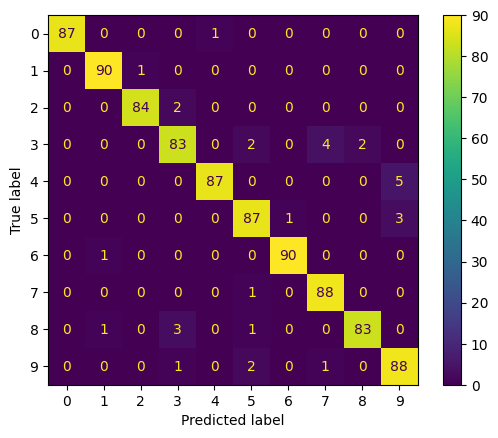

In [44]:
disp_transformed = metrics.ConfusionMatrixDisplay.from_predictions(y_test, transformed_predicted)
disp.figure_.suptitle("Confusion Matrix after DimRed")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()


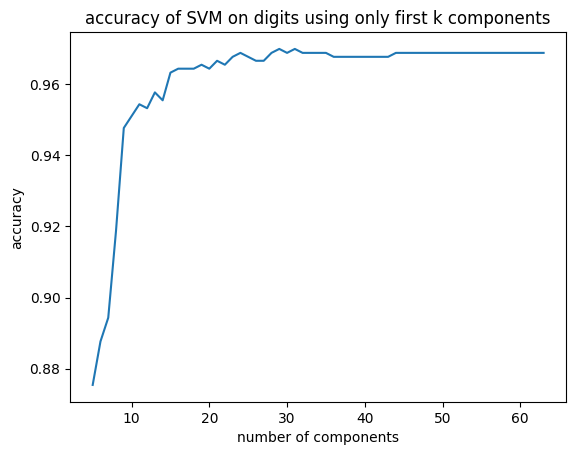

In [47]:
# Let's see the effect on performance as we change the dimensionality.
def train_and_predict_accuracy(n_components):
    sklearn_pca = PCA(n_components=n_components).fit(X_train)

    X_transform_train = sklearn_pca.transform(X_train)
    X_transform_test = sklearn_pca.transform(X_test)

    # Create a classifier: a support vector classifier
    clf_low_dim = svm.SVC(gamma=0.001)

    # Learn the digits on the train subset in the lower dimensional space
    clf_low_dim.fit(X_transform_train, y_train)

    # Predict the value of the digit on the test subset
    transformed_predicted = clf_low_dim.predict(X_transform_test)
    clf.fit(X_train, y_train)

    return metrics.accuracy_score(y_test, transformed_predicted)

components = range(5,64)
accs = [train_and_predict_accuracy(n) for n in components]

plt.title("accuracy of SVM on digits using only first k components")
plt.xlabel("number of components")
plt.ylabel("accuracy")
plt.plot(components, accs)


Decreasing the dimensionality didn't change the performance much, and in fact, lowering the number of components to 8 or 10 results in a pretty severe penalty in performance.  Let's try a different image dataset.

In [21]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [30]:
# flatten the images
n_samples = len(faces.images)
data = faces.images.reshape((n_samples, -1))
print(data.shape)
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, faces.target, test_size=0.5, shuffle=True
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)


(400, 4096)


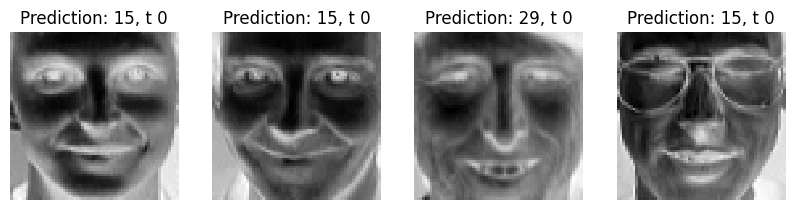

In [31]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
i=0
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    true_label = faces.target[i]
    image = image.reshape(64, 64)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}, t {true_label}")
    i+=1

In [32]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)


Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         6
          13       1.00      0.67      0.80         3
          14       0.00      0.00      0.00         4
          15       0.01      1.00      0.03         2
          16       0.00   

/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [37]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=64).fit(X_train)

X_transform_train = sklearn_pca.transform(X_train)
X_transform_test = sklearn_pca.transform(X_test)

# Create a classifier: a support vector classifier
clf_low_dim = svm.SVC(gamma=0.001)

# Learn the digits on the train subset in the lower dimensional space
clf_low_dim.fit(X_transform_train, y_train)

# Predict the value of the digit on the test subset
transformed_predicted = clf_low_dim.predict(X_transform_test)

In [38]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)


Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         6
          13       1.00      0.67      0.80         3
          14       0.00      0.00      0.00         4
          15       0.01      1.00      0.03         2
          16       0.00   

/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Here, we were only able to get 5% accuracy using SVM.  The dataset here was much larger (64x64, or 4096 dimensions), and there were actually 40 classes.  And dimensionality reduction didn't have much effect.

The problem we are facing here is that the data is probably lower dimensional, but we aren't able to find those dimensions using PCA.  Soon, we will learn about neural networks that find this improved representation as part of their learning process.